In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import seaborn as sns

In [ ]:
from random import random
from tqdm.notebook import tqdm

In [ ]:
import time
import multiprocess as mp

### Read data

### Mutation detection

In [ ]:
from mutation_detection import *
from LOH_detection import *

In [ ]:
start_time = time.time()
posteriors = get_posteriors(ref, alt, n_threads = 6)
print('Runtime:', (time.time() - start_time) / 60, 'min')
pd.DataFrame(posteriors, columns = ['R', 'H', 'A', 'RH', 'HA'], index = df_ref.index).to_csv('./posteriors.csv')

In [ ]:
df_posteriors = pd.read_csv('./posteriors.csv', index_col = (0,1))
posteriors = df_posteriors.to_numpy()

In [ ]:
mutated_idx, mut_type_idx = np.where(posteriors[:,3:] > 1 - 1 / posteriors.shape[0])
n_mutated = mutated_idx.size
homos = [['R', 'A'][i] for i in mut_type_idx]

In [ ]:
corr_posteriors = get_corr_posteriors(ref[mutated_idx,:], alt[mutated_idx,:], homos, corr_prior = 1/2) 

In [ ]:
pd.DataFrame(data = {'correlation posterior': np.concatenate((corr_posteriors, [0])), 'mutation type': ['H' + h for h in homos]}, 
             index = df_posteriors.index[mutated_idx]).to_csv('./corr_posteriors.csv')

### Data generator

In [1]:
from data_generator import *

In [2]:
dg = DataGenerator(25, 100, mut_prop = 0.5)
dg.random_tree()

In [3]:
ref_raw, alt_raw = dg.generate_reads()

  0%|          | 0/25 [00:00<?, ?it/s]

### Tree inference with generated data

In [4]:
from tree_inference import *
from mutation_detection import likelihood_matrices
from utilities import path_len_dist

In [5]:
import matplotlib.pyplot as plt

In [6]:
ref, alt, gt1, gt2 = filter_mutations(ref_raw, alt_raw)

In [7]:
len(gt1)

46

In [8]:
likelihoods1, likelihoods2 = likelihood_matrices(ref, alt, gt1, gt2)

#### True tree

In [ ]:
optz = TreeOptimizer()
optz.fit(likelihoods1, likelihoods2, reversible = True)
optz.ct = dg.tree.copy()
optz.ct.n_mut = optz.n_mut
optz.update_ct()

In [ ]:
optz.ct_joint

In [ ]:
print('Distance matrix MSE to real tree:', path_len_dist(optz.ct, dg.tree))

In [ ]:
optz.mt.fit_structure(optz.ct)
optz.mt_L[:,optz.mt.root.ID] = np.sum(optz.likelihoods1, axis = 1)
optz.update_mt()

In [ ]:
optz.mt_joint / likelihoods1.size

#### All mutations reversible

In [9]:
optz = TreeOptimizer()
optz.fit(likelihoods2, likelihoods1, reversible = True)
print('Distance matrix MSE to real tree:', path_len_dist(optz.ct, dg.tree))

Distance matrix MSE to real tree: 13.053333333333333


In [10]:
optz.optimize(spaces = ['m'])

[Mutation Tree Space] convergence after 5483 steps and 58 move(s).
[Mutation Tree Space] convergence after 1024 steps and 2 move(s).
[Mutation Tree Space] convergence after 460 steps and 0 move(s).


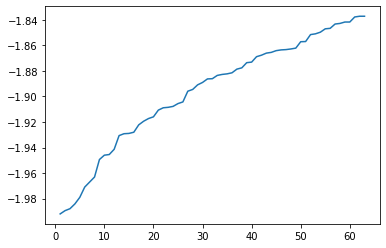

In [11]:
mean_likelihoods = np.array(optz.likelihood_history) / likelihoods1.size
plt.plot(mean_likelihoods)

In [12]:
print('MSE to real distance matrix:', path_len_dist(optz.ct, dg.tree))
print('Cell tree mean loglikelihood:', optz.ct_joint / likelihoods1.size)
print('Mutation tree mean loglikelihood:', optz.mt_joint / likelihoods1.size)

MSE to real distance matrix: 4.546666666666667
Cell tree mean loglikelihood: -1.0431376811304347
Mutation tree mean loglikelihood: -1.8372870715652172


#### No mutation reversible

In [ ]:
optz = TreeOptimizer()
optz.fit(likelihoods1, likelihoods2, reversible = False)
print('Distance matrix MSE to real tree:', path_len_dist(optz.ct, dg.tree))

In [ ]:
optz.optimize()

In [ ]:
mean_likelihoods = np.array(optz.likelihood_history) / likelihoods1.size
plt.plot(mean_likelihoods)

In [ ]:
print('MSE to real distance matrix:', path_len_dist(optz.ct, dg.tree))
print('Cell tree mean loglikelihood:', optz.ct_joint / likelihoods1.size)
print('Mutation tree mean loglikelihood:', optz.mt_joint / likelihoods1.size)

### Make figures